In [2]:
import statsmodels
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_predict
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

In [3]:
ar1 = np.array([1,0.33])
ma1 = np.array([1,0.9])
simulated_arma_data = ArmaProcess(ar1,ma1).generate_sample(nsample=10000)

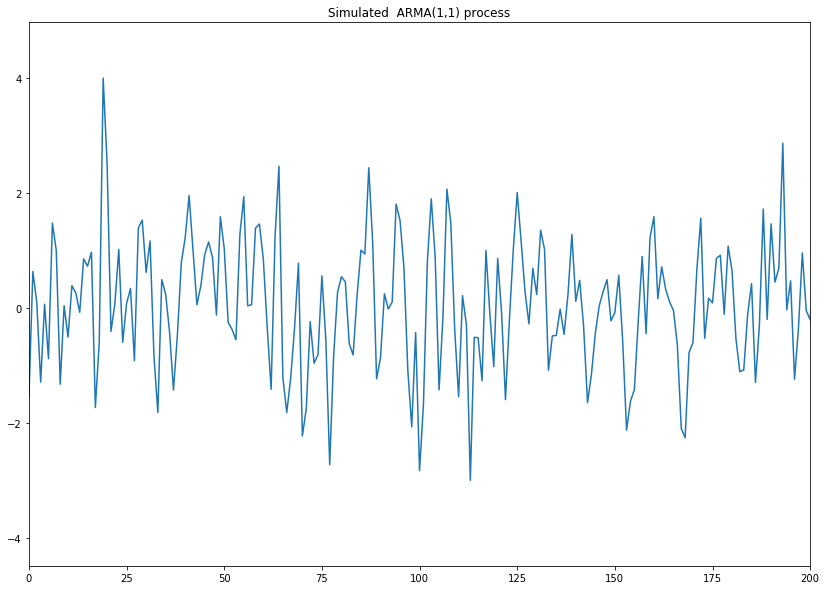

In [6]:
fig,ax= plt.subplots(figsize=(14,10))
ax.plot(simulated_arma_data)
ax.set_xlim([0,200])
plt.title('Simulated  ARMA(1,1) process')
plt.show()

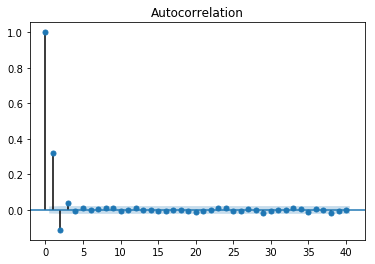

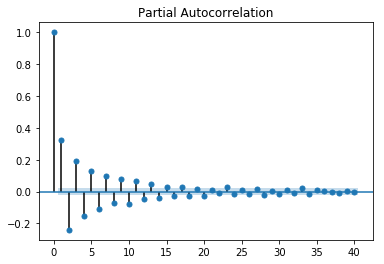

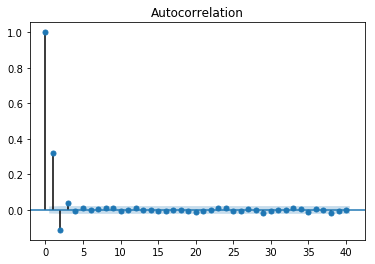

In [8]:
plot_pacf(simulated_arma_data)
plot_acf(simulated_arma_data)

In [9]:
ar2 = np.array([1,0.33,0.5])
ma2 = np.array([1,0.9,0.3])

simulated_arma2_data = ArmaProcess(ar2,ma2).generate_sample(nsample=10000)

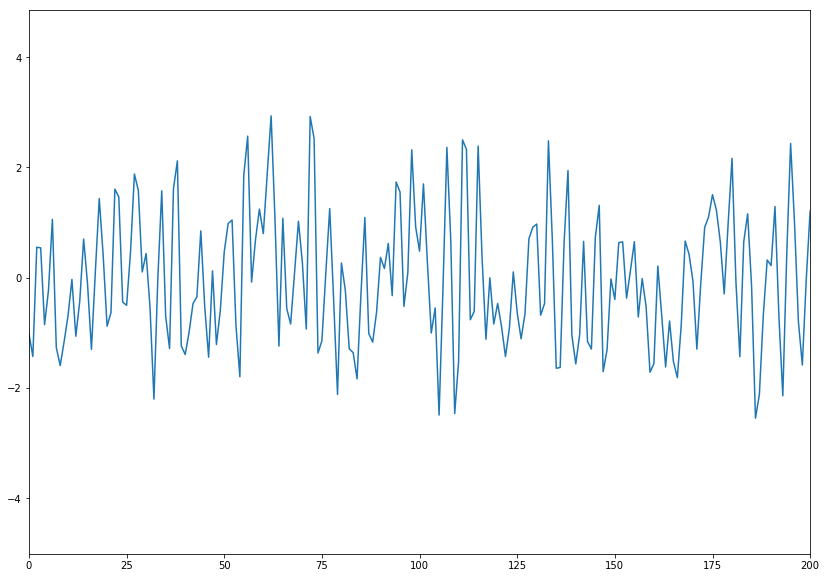

In [10]:
fig, ax = plt.subplots(figsize=(14,10))
ax.plot(simulated_arma2_data)
ax.set_xlim([0,200])
plt.show()

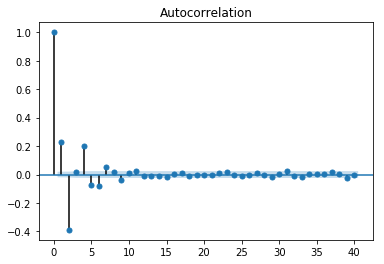

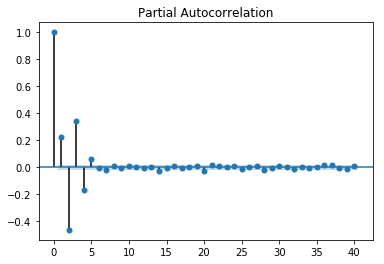

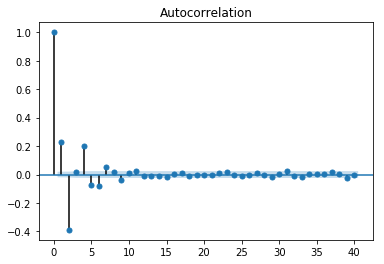

In [11]:
plot_pacf(simulated_arma2_data)
plot_acf(simulated_arma2_data)

In [12]:
data = pd.read_csv('jj.csv', parse_dates=['date'])

In [13]:
data.head()

,date,data
0,1960-01-01,0.71
1,1960-04-01,0.63
2,1960-07-02,0.85
3,1960-10-01,0.44
4,1961-01-01,0.61


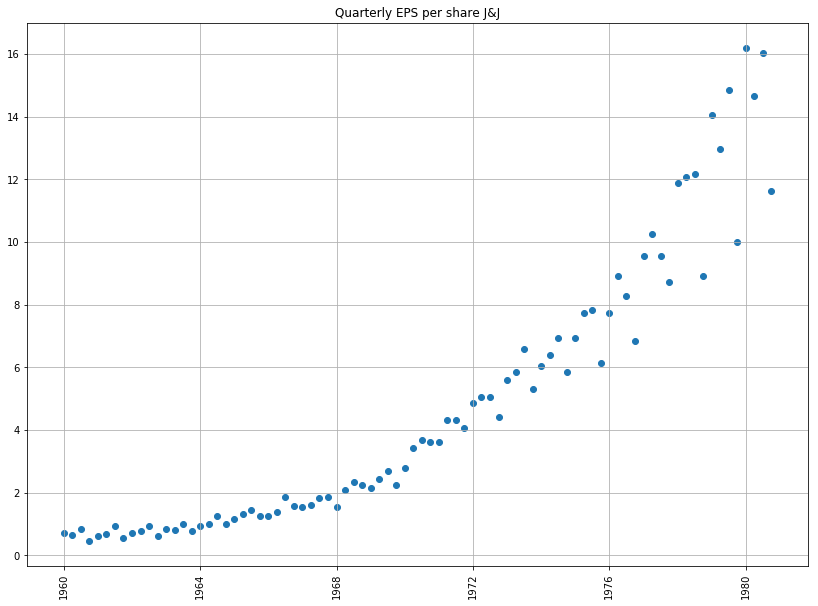

In [15]:
fig, ax = plt.subplots(figsize=(14,10))
ax.scatter(data['date'], data['data'])
plt.title('Quarterly EPS per share J&J')
plt.xticks(rotation=90)
plt.grid(True)

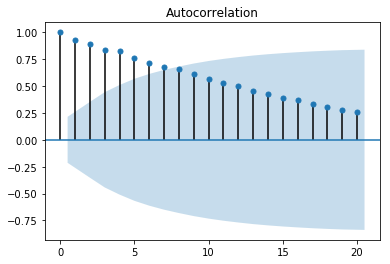

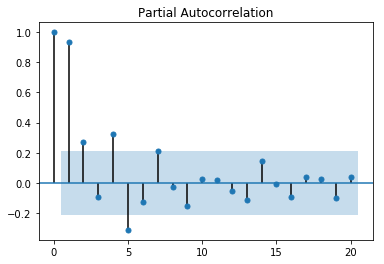

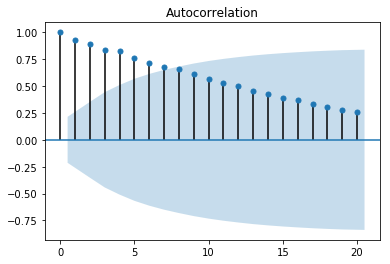

In [16]:
plot_pacf(data['data'])
plot_acf(data['data'])

In [20]:
ad_fuller = adfuller(data['data'])
print('ADF Statistics: {}'.format(ad_fuller[0]))
print('p-value: {}'.format(ad_fuller[1]))

ADF Statistics: 2.742016573457474
p-value: 1.0


In [21]:
log_data = np.log(data['data'])
data['data'] = log_data.diff()
data = data.drop(data.index[0])
data.head()

,date,data
1,1960-04-01,-0.119545
2,1960-07-02,0.299517
3,1960-10-01,-0.658462
4,1961-01-01,0.326684
5,1961-04-02,0.123233


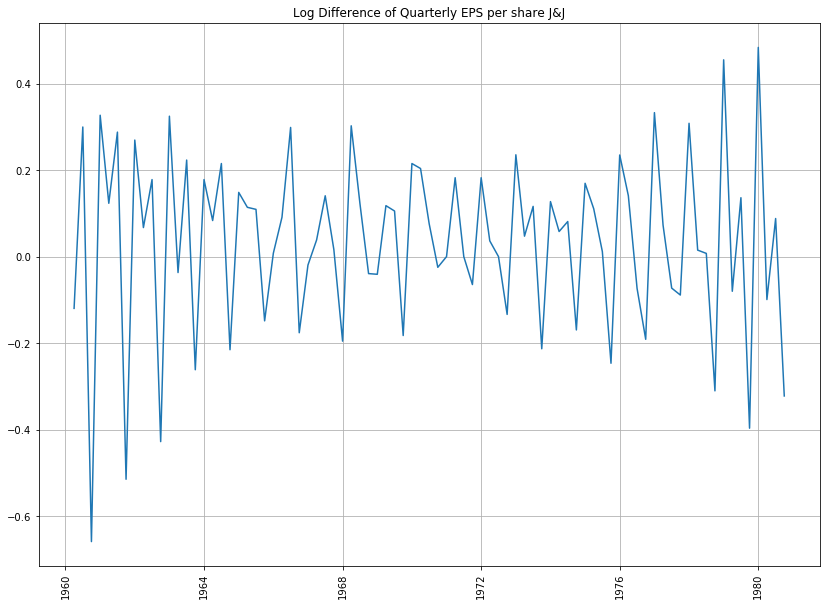

In [23]:
fig, ax = plt.subplots(figsize=(14,10))
ax.plot(data['date'], data['data'])
plt.title('Log Difference of Quarterly EPS per share J&J')
plt.xticks(rotation=90)
plt.grid(True)

In [25]:
ad_fuller = adfuller(data['data'])
print('ADF Statistic: {}'.format(ad_fuller[0]))
print('p-value: {}'.format(ad_fuller[1]))

ADF Statistic: -4.317043945811839
p-value: 0.000414973140444062


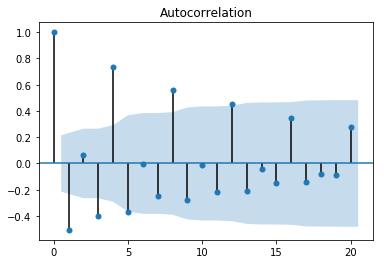

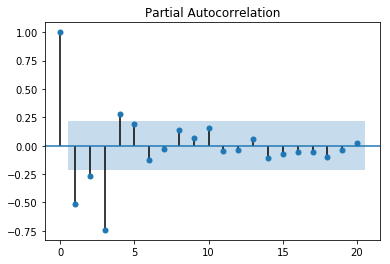

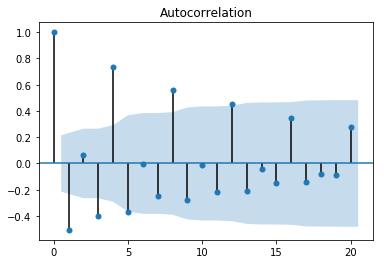

In [26]:
plot_pacf(data['data'])
plot_acf(data['data'])

In [35]:
def optimize_arima(order_list, exog):
    results = []
    for order in order_list:
        try:
            model = SARIMAX(exog, order=order).fit(disp=-1)
        except:
            continue
        aic = model.aic
        results.append([order, model.aic])
    
    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,d,q)', 'AIC']
    result_df = result_df.sort_values(by='AIC',ascending=True).reset_index(drop=True)
    return result_df

In [36]:
ps = range(0,8,1)
d = 1
qs = range(0,8,1)

order_list = []
for p in ps:
    for q in qs:
        order = tuple([p, 1, q])
        order_list.append(order)

result_df = optimize_arima(order_list, exog = data['data'])
result_df

,"(p,d,q)",AIC
0,"(7, 1, 1)",-142.083435
1,"(3, 1, 3)",-142.041613
2,"(7, 1, 5)",-140.551190
3,"(3, 1, 1)",-140.470720
4,"(3, 1, 4)",-140.454169
...,...,...
56,"(1, 1, 1)",-37.105501
57,"(0, 1, 1)",-14.645882
58,"(2, 1, 0)",14.952068
59,"(1, 1, 0)",17.545808


In [37]:
best_model = SARIMAX(data['data'], order=(3,1,3)).fit()
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                   data   No. Observations:                   83
Model:               SARIMAX(3, 1, 3)   Log Likelihood                  78.021
Date:                Mon, 11 Jan 2021   AIC                           -142.042
Time:                        16:55:13   BIC                           -125.195
Sample:                             0   HQIC                          -135.278
                                 - 83                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9947      0.054    -18.279      0.000      -1.101      -0.888
ar.L2         -0.9744      0.051    -19.062      0.000      -1.075      -0.874
ar.L3         -0.9418      0.031    -30.455      0.0

In [38]:
ljung_box, p_value = acorr_ljungbox(best_model.resid)
print('Ljung-Box-test: {}'.format(ljung_box))
print('P-Value: {}'.format(p_value))

Ljung-Box-test: [ 5.9434771   5.96392839  6.19220697  6.96626342  6.96626574  6.99203764
  9.55557524  9.56656024  9.78023151 10.68674282 11.04990447 11.14841417
 11.73021881 11.73347255 11.83956953 11.86394239 11.95444124 12.50768902
 13.03332467 13.23719757 14.18666037 14.36444347 16.80236502 16.85080455
 16.9189493  17.11898945 17.44770238 17.51787801 19.93794769 22.75788616
 23.05868478 23.10932078 25.10459878 25.56250689 25.71407821 27.77964197
 28.74916894 28.76180525 28.88524031]
P-Value: [0.01477185 0.05069316 0.10262433 0.13768183 0.22316128 0.32158418
 0.21518799 0.29677412 0.36856807 0.38243863 0.43909196 0.51624425
 0.54988035 0.62769735 0.6911296  0.75329146 0.8028881  0.81995034
 0.83686071 0.86697649 0.86144864 0.88804131 0.81883587 0.85495505
 0.8847125  0.90544417 0.91949461 0.93764734 0.89484554 0.82508076
 0.84699826 0.8748207  0.83607396 0.85081619 0.87390482 0.83496115
 0.83205196 0.86038291 0.88204841]


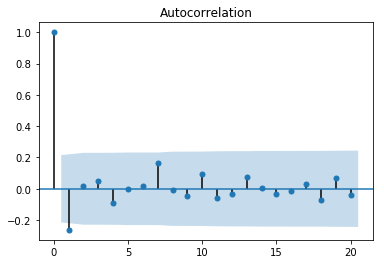

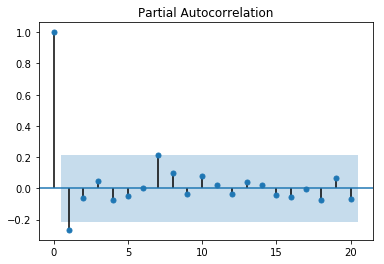

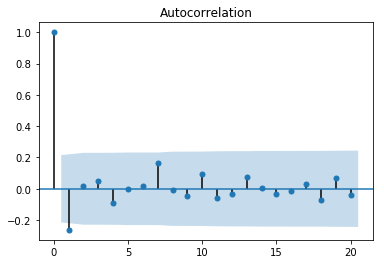

In [39]:
plot_pacf(best_model.resid)
plot_acf(best_model.resid)

In [47]:
predict = best_model.get_prediction()

In [54]:
predicted_values = predict.predicted_mean
fig = predict.plot()
plt.plot(data['data'])

AttributeError: 'PredictionResults' object has no attribute 'plot'

In [51]:
real_values = data['data'].cumsum()
predicted_values = predicted_values.cumsum()
plt.plot(predicted_values)
plt.plot(real_values)

NameError: name 'predicted_values' is not defined